## Malawi Consumption Analysis

In this notebook, we are going to analyze a dataset of around ~11,000 households in Malawi collected in 2019. The dataset contains over 290 variables related to education, health, food consumption, and other indicators that might be predictive of overall consumption.

### Data Loading and Cleaning

First, let's import the necessary libraries. We will need pandas for data manipulation, numpy for numerical operations, and matplotlib and seaborn for data visualization.

In [27]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

In [28]:
# Load the survey data
data = pd.read_csv('../data/raw/survey.csv')

In [29]:
data.head()

,unique_id,region,district,urban_rural,weight,hhsize,always_here,highest_father_education,highest_mother_education,language,...,Unusually High Costs of Agricultural Inputs,Unusually High Level of Crop Pests or Disease,Unusually High Level of Livestock Disease,Unusually High Prices for Food,Unusually Low Prices for Agricultural Output,deaths,consumption,has_phone,latitude,longitude
0,7d78f2c5da59436d9bde9b09ea8a8aaf,North,Chitipa,RURAL,93.7194,4,1,NONE,NONE,SUKWA/NDALI,...,1,0,0,1,0,0,99918.367188,1,NaN,NaN
1,7144cc6d29b3485d9e6d6188b255c756,North,Chitipa,RURAL,93.7194,4,1,NONE,NONE,other,...,1,1,1,1,0,0,169322.718750,0,NaN,NaN
2,9936d103bf974a93afbc63d477b8b3f2,North,Chitipa,RURAL,93.7194,4,1,NONE,NONE,other,...,1,0,0,0,0,0,93644.257812,1,NaN,NaN
3,cc8f211413cd493e83e01a96aba95bbb,North,Chitipa,RURAL,93.7194,5,1,NONE,NONE,other,...,1,0,0,0,0,0,452758.093750,1,NaN,NaN
4,e50cfa8d11b44d56891e0fad015b07c7,North,Chitipa,RURAL,93.7194,5,0,NONE,NONE,OTHER,...,0,0,0,0,0,0,183333.437500,0,NaN,NaN


To compute the fraction of the population that lives in extreme poverty (defined as having a per-capita consumption below $1.90/day), we can follow these steps:

1. Convert the Poverty Threshold to Local Currency: First, we need to convert the daily poverty threshold of $1.90 to the local currency, which is Kwacha in this case. 

2. We will also convert the daily amount to a yearly amount for comparison with the 'consumption' column in the survey data, which represents per-capita yearly consumption. Let's assume the conversion rate from USD to Kwacha is 720 (as of the time of this analysis)

3. We will then compute the number of individuals living on less than $1.90

In [30]:
# Conversion rate from USD to Kwacha
conversion_rate = 720

# Daily poverty threshold in USD
poverty_threshold_daily_usd = 1.90

# Convert daily poverty threshold in USD to yearly threshold in Kwacha
poverty_threshold_yearly_kwacha = poverty_threshold_daily_usd * 365 * conversion_rate

# Calculate per-capita consumption
data['per_capita_consumption'] = data['consumption'] / data['hhsize']

# Create a new column 'in_poverty' that is True if the per-capita consumption is below the poverty threshold
data['in_poverty'] = data['per_capita_consumption'] < poverty_threshold_yearly_kwacha


# Calculate the number of people in extreme poverty
people_in_poverty = data[data['in_poverty']]['hhsize'].sum()

# Calculate the total number of people
total_people = data['hhsize'].sum()

# Calculate the fraction of the population in extreme poverty
fraction_in_poverty = people_in_poverty / total_people

fraction_in_poverty

0.9893612806086061

This fraction of ~98% is significantly higher than the World Banks poverty projection based on GDP per capita growth, the share of people living with less than $2.15/day increased slightly from 70.1 percent to 72 percent between 2019 and 2023.
Our figure is possibily higher because of sampling criteria. The study might have oversampled poorer households, which would lead to a higher poverty rate.

### Choproleth map:  Respondents living in the district of Mangochi

In [31]:
# Load the GeoJSON file
geo_data = gpd.read_file('../data/raw/tas.geojson')
geo_data = geo_data.to_crs(epsg=4326)

geo_data.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,MWI.1.1_1,MWI,Malawi,MWI.1_1,Balaka,NA,BalakaTown,NA,NA,Town,Town,NA,NA,"MULTIPOLYGON (((34.96680 -14.97460, 34.97690 -..."
1,MWI.1.2_1,MWI,Malawi,MWI.1_1,Balaka,NA,TAKalembo,NA,NA,TraditionalAuthority,TraditionalAuthority,NA,NA,"MULTIPOLYGON (((35.19280 -15.03790, 35.18410 -..."
2,MWI.1.3_1,MWI,Malawi,MWI.1_1,Balaka,NA,TANsamala,NA,NA,TraditionalAuthority,TraditionalAuthority,NA,NA,"MULTIPOLYGON (((35.07920 -15.30380, 35.07740 -..."
3,MWI.2.1_1,MWI,Malawi,MWI.2_1,Blantyre,NA,BlantyreCity,NA,NA,City,City,NA,NA,"MULTIPOLYGON (((34.99530 -15.70190, 34.99620 -..."
4,MWI.2.2_1,MWI,Malawi,MWI.2_1,Blantyre,NA,TAChigaru,NA,NA,TraditionalAuthority,TraditionalAuthority,NA,NA,"MULTIPOLYGON (((34.96080 -15.50940, 34.95810 -..."


## Respondents living in the Traditional Authorities (TAs) in Mangochi District, Malawi

1. Loading the Data: We first loaded the GeoJSON data containing polygons that define the geographic boundaries of the TAs in Mangochi district. We also loaded the survey data containing household-level information, including geographic coordinates (latitude and longitude).

2. Data Preparation: To facilitate geographic analysis, we transformed the survey data into a GeoDataFrame, creating a shapely.Point object from the latitude and longitude of each household. We also converted the Coordinate Reference Systems (CRS) of the survey data and the GeoJSON data to match each other.

3. Assigning Households to TAs: For each household in Mangochi district, we checked which TA polygon its geographic point falls within. We intended to assign each household to a TA by adding a 'TA' column to the survey data.

4. Calculating Poverty Rates: We planned to calculate the poverty rate for each TA by grouping the survey data by TA and computing the mean of a binary variable indicating whether each household's per capita consumption is below the poverty line.



In [32]:
# Filter out households in Mangochi district
mangochi_data = data[data['district'] == 'Mangochi'].copy()

# Filter the GeoJSON data to only include the TAs in Mangochi
mangochi_geo_data = geo_data[(geo_data['NAME_1'] == 'Mangochi') & (geo_data['TYPE_2'] == 'TraditionalAuthority')]

# Create an empty column for the TA in the household data
mangochi_data['TA'] = ''

# For each household in Mangochi, check which TA it belongs to
for i, row in mangochi_data.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        point = Point(row['longitude'], row['latitude'])
        for j, poly in mangochi_geo_data.iterrows():
            if poly['geometry'].contains(point):
                mangochi_data.loc[i, 'TA'] = poly['NAME_2']
                break


# Calculate the poverty rates for each TA
poverty_rates = mangochi_data.groupby('TA')['in_poverty'].mean()

# Display the results
poverty_rates

TA
               0.969849
TAChimwala     0.961538
TAJalasi       1.000000
TAKatuli       1.000000
TAMakanjila    1.000000
TAMponda       0.967742
TANankumba     0.968750
Name: in_poverty, dtype: float64

## Choropleth Map 
Using the calculated poverty rates and the GeoJSON data, we created a choropleth map using GeoPandas and Matplotlib. This type of map visualizes the geographic distribution of a variable (in this case, the poverty rate) by coloring each geographic region (TA) according to its value of the variable.

/var/folders/v9/y7yl8hq11zl39wyxhcbfpg_h0000gn/T/ipykernel_83288/240536655.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(mangochi_geo_data.geometry.centroid.x, mangochi_geo_data.geometry.centroid.y, mangochi_geo_data['NAME_2']):


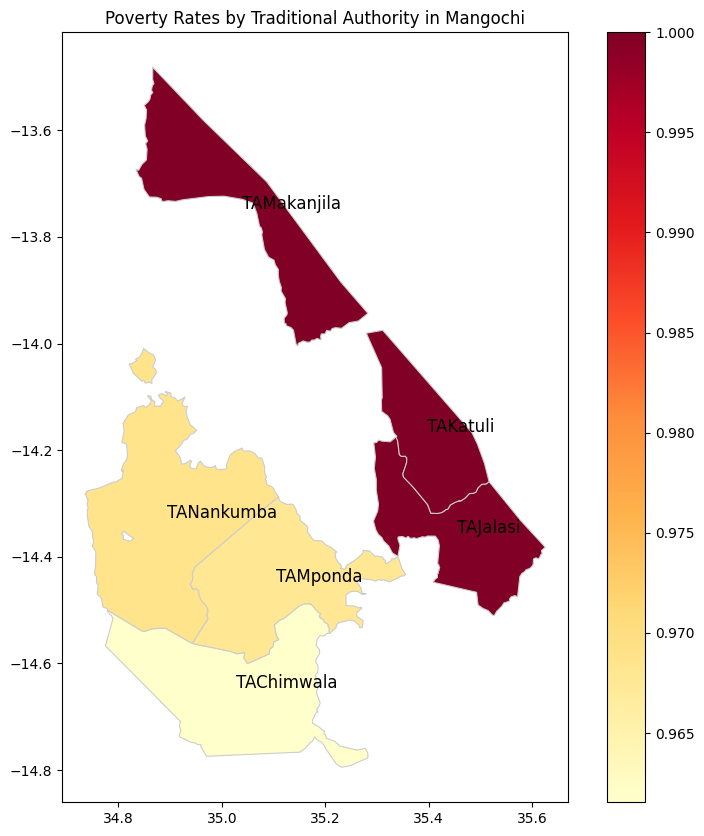

In [33]:
# Convert the poverty rates to a DataFrame
poverty_rates_df = poverty_rates.reset_index()

# Merge the poverty rates with the GeoDataFrame
mangochi_geo_data = mangochi_geo_data.merge(poverty_rates_df, left_on='NAME_2', right_on='TA', how='left')

# Create a choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mangochi_geo_data.plot(column='in_poverty', ax=ax, legend=True, cmap='YlOrRd', linewidth=0.8, edgecolor='0.8')

# Add TA names
for x, y, label in zip(mangochi_geo_data.geometry.centroid.x, mangochi_geo_data.geometry.centroid.y, mangochi_geo_data['NAME_2']):
    ax.text(x, y, label, fontsize=12)

plt.title('Poverty Rates by Traditional Authority in Mangochi')
plt.show()